In [1]:
import numpy as np
import numpy.random as npr
from scipy import sparse
from scipy.spatial.distance import cosine
from time import time

from matplotlib import pyplot as plt
from matplotlib import animation, rc, collections
from IPython.display import HTML

In [2]:
def get_weights_rand(shape, prob):
    """Return a weights matrix with prob amount of random connections activated.
    
    Args:
        shape: (int) number of neurons in network
        prob: (float) fraction of connections to be activated
    
    Returns:
        weights: (numpy matrix) connectivity weight matrix
    """
    # THIS IS NOT QUITE RANDOM...
    l = int(shape*shape*prob)
    rows = npr.choice(range(shape), l)
    cols = npr.choice(range(shape), l)
    weights = sparse.csr_matrix((np.ones(l), (rows, cols)), shape=(shape,shape))
    weights.setdiag(0)
    return weights

n = 100000 # number of neurons in network; CA3 is 330,000 (or double)

now = time()
W = get_weights_rand(n, p) # connectivity weight matrix; are neurons connected?
print('made W in', time() - now)
W.shape

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


made W in 191.84898209571838


(100000, 100000)

In [50]:
def get_patterns(activity, num_neurons, num_patterns):
    """Return a matrix where each row is a pattern with activity level activity.
    
    Args:
        activity: (float) avg activity level per pattern
        num_neurons: (int) num neurons in network
        num_patterns: (int) num patterns to generate
    
    Returns:
        patterns: (numpy matrix) set of patterns shape=(num_patterns, num_neurons)
    """
    return npr.binomial(1, activity, size=(num_patterns, num_neurons))

def get_syn_weights(patterns):
    """Return synaptic weight matrix.
    
    Args:
        patterns: (numpy matrix) set of patterns, shape=(num_patterns, num_neurons)
        
    Returns:
        syn: (numpy matrix) synaptic weight matrix, shape=(num_neurons, num_neurons)
    """
    num_patterns, num_neurons = patterns.shape
    row_ind = []
    col_ind = []
    for i in range(num_patterns):
        p = sparse.csr_matrix(patterns[i, :])
        mat = p.multiply(p.T)
        rows, cols = np.nonzero(mat)
        row_ind = np.concatenate([row_ind, rows])
        col_ind = np.concatenate([col_ind, cols])
    o = np.ones(len(row_ind))
    return sparse.csr_matrix((o, (row_ind, col_ind)), shape=(num_neurons, num_neurons))

p = .03                   # connection probability for weight matrix
m = 3                   # number of patterns to store
f = 0.001                  # average activity level of each pattern

M = get_patterns(f, n, m)  # patterns
J = get_syn_weights(M)     # synaptic weight matrix J; how much are neurons connected?
W_J = W.multiply(J)

M.shape, J.shape, W_J.shape

((3, 100000), (100000, 100000), (100000, 100000))

Let's plot the synaptic connection matrix, W * J, to see all the connections in the simulation:

num connections: 895


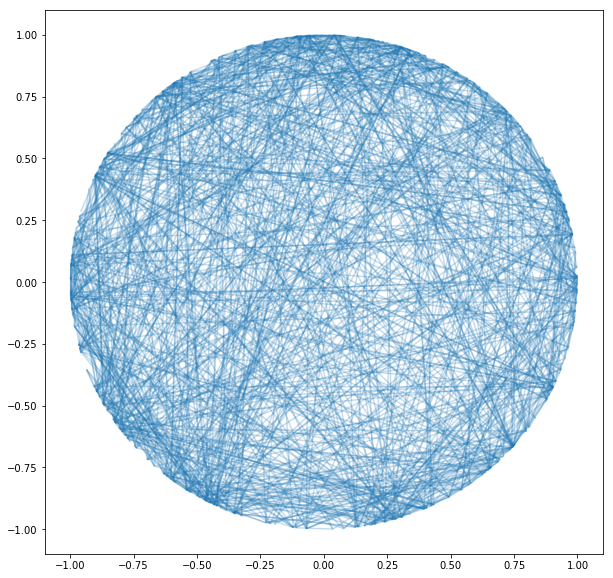

<Figure size 432x288 with 0 Axes>

In [51]:
mat = W_J

rows, cols = mat.nonzero()
all_num = np.unique(rows+cols)
print('num connections:', len(all_num))

fig, ax = plt.subplots()
fig.set_size_inches(10,10)

lines = [[(np.cos(r),np.sin(r)), (np.cos(c),np.sin(c))] for r, c in zip(rows, cols)]
lc = collections.LineCollection(lines, alpha=0.25)

ax.add_collection(lc)
ax.autoscale()
ax.margins(0.05)

plt.show()
plt.clf()

Now let's plot a pattern we created, and the connections it would light up:

num connections: 284
num nodes: 102


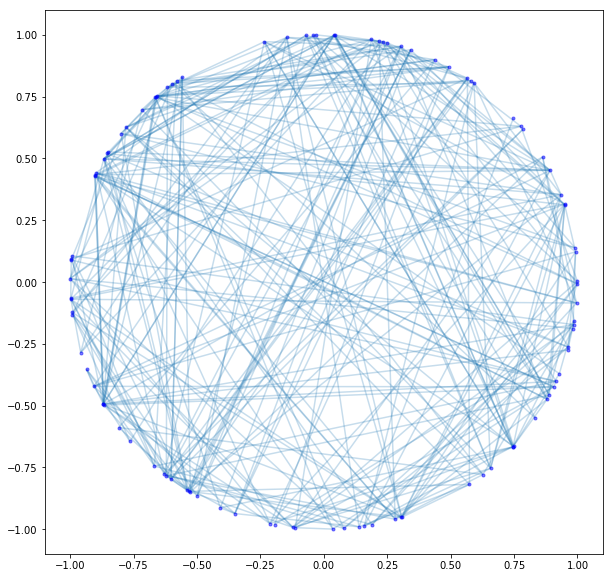

<Figure size 432x288 with 0 Axes>

In [52]:
def show_mat_and_pat(mat, pattern, outer_pattern=[]):
    rows, cols = mat.nonzero()
    all_num = np.unique(rows+cols)
    print('num connections:', len(all_num))
    print('num nodes:', len(pattern.nonzero()[0]))

    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)

    lines = [[(np.cos(r),np.sin(r)), (np.cos(c),np.sin(c))] for r, c in zip(rows, cols)]
    lc = collections.LineCollection(lines, alpha=0.25)

    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.05)

    dots = pattern.nonzero()
    ax.plot(np.cos(dots), np.sin(dots), 'b.', alpha=0.5)
    
    if len(outer_pattern) > 0:
        dots = outer_pattern.nonzero()
        ax.plot(1.05*np.cos(dots), 1.05*np.sin(dots), 'g.')

    plt.show()
    plt.clf()

pattern = M[0,:]
mat = W_J.multiply(pattern)
show_mat_and_pat(mat, pattern)

Now let's degrade a pattern, and have a look at what a degraded pattern looks like:

original pattern of len 100000 with 102 fires
deg_fires: 51
nonfires: 99898
spur_fires: 99
correlation between original and degraded: 0.411592248977
num connections: 132
num nodes: 150


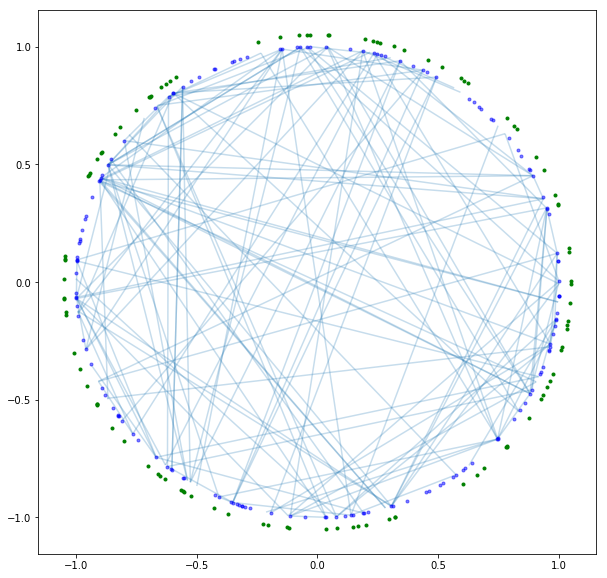

<Figure size 432x288 with 0 Axes>

In [53]:
def get_degraded_pattern(pattern, valid, spurious):
    """Return degraded pattern for input to simulation to do pattern completion.
    
    Args:
        pattern: (array) pattern to degrade, 0s or 1s, shape=(num_neurons)
        valid: (float) fraction of valid firing neurons
        spurious: (float) fraction of spurious firing neurons
    
    Return:
        deg_pat: (array) degraded pattern, 0s or 1s, shape=(num_neurons)
    """
    print('original pattern of len {} with {} fires'.format(len(pattern), sum(pattern)))
    fires = np.nonzero(pattern)[0]
    deg_fires = npr.choice(fires, size=int(valid*len(fires)), replace=False)
    print('deg_fires:', len(deg_fires))

    nonfires = np.where(pattern == 0)[0]
    spur_fires = npr.choice(nonfires, size=int(spurious*len(nonfires)), replace=False)
    print('nonfires:', len(nonfires))
    print('spur_fires:', len(spur_fires))
    
    all_fires = np.concatenate((deg_fires, spur_fires), axis=0)

    deg_pat = np.zeros(shape=(len(pattern),))
    deg_pat[all_fires] = 1
    
    return deg_pat

def get_correlation(p1, p2):
    p1_ = p1 - (sum(p1)/len(p1))
    p2_ = p2 - (sum(p2)/len(p2))
    return 1 - cosine(p1_, p2_)

b_vald = .5  # fraction of valid firing neurons in patterns
b_spur = 0.001  # fraction of spurious firing neurons in patterns

pattern = M[0, :]
badpat = get_degraded_pattern(pattern, b_vald, b_spur)
print('correlation between original and degraded:', get_correlation(pattern, badpat))

mat = W_J.multiply(badpat)
show_mat_and_pat(mat, badpat, outer_pattern=pattern)

In [54]:
def simulate(in_pattern, out_pattern, con_mat, syn_mat, g0, g1, cycles=10, pprint=False):
    """Return final matrix of updates.
    
    Args:
        in_pattern: (array) degraded pattern to start
        out_pattern: (array) original pattern to attempt to recall
        con_mat: (matrix) connectivity matrix
        syn_mat: (matrix) synaptic weights matrix
        g0: (float) firing threshold
        g1: (float) inhibition factor
        cycles: (int) num times to run iteration
    
    Return:
        curr_mat: (matrix) end state matrix
    """
    n = len(in_pattern)
    W_J = con_mat.multiply(syn_mat)
    state = sparse.csr_matrix(np.matrix(in_pattern)).T
    all_inter = []
    if pprint:
        print('{:<10} {:<10} {:<10}'.format('steps', 'correl', 'num fires'))
    for i in range(cycles):
        if pprint:
            curr = state.T.toarray()[0]
            print('{:<10} {:<10.2f} {:<10}'.format(i, get_correlation(curr, out_pattern), sum(curr)))
        _inter = W_J.dot(state)
        all_inter.append((_inter, state))
        h = (1/n) * _inter
        condition = h - ( (1/n) * g1 * np.sum(state) )
        state = condition > g0
        state = _inter > 0.
    curr = state.T.toarray()[0]
    return W_J, all_inter, get_correlation(curr, out_pattern)

g_0 = 7 * 10**-6
g_1 = 0.0
W_J, inters, res = simulate(badpat, pattern, W, J, g_0, g_1, pprint=True)

steps      correl     num fires 
0          0.41       150.0     
1          0.88       79        
2          0.94       90        
3          0.95       93        
4          0.97       96        
5          0.98       97        
6          0.98       97        
7          0.98       97        
8          0.98       97        
9          0.98       97        


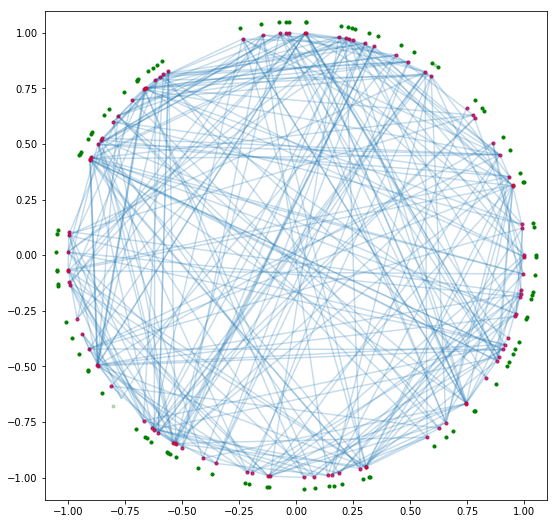

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9)

def init():
    good = pattern.nonzero()[0]
    ax.plot(np.cos(good), np.sin(good), 'g.', alpha=0.25)
    
    lines = []
    lc = collections.LineCollection(lines, alpha=0.25)
    ax.add_collection(lc)
    
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.margins(0.1)
    return (lc,)

#Define the animation function, which is called for each new frame:

def animate(i):
    # state is what created _inter
    _inter, state = inters[i]
    connections = W_J.multiply(state)
    rows, cols = connections.nonzero()
    
    lines = [[(np.cos(c),np.sin(c)), (np.cos(r),np.sin(r))] for r, c in zip(rows, cols)]
    lc = collections.LineCollection(lines, alpha=0.25)
    
    ax.clear()
    ax.add_collection(lc)
    
    start = state.nonzero()[0]
    ax.plot(np.cos(start), np.sin(start), 'b.', alpha=0.5)
    
    end = _inter.nonzero()[0]
    ax.plot(np.cos(end), np.sin(end), 'r.', alpha=0.5)
    
    
    good = pattern.nonzero()[0]
    ax.plot(1.05*np.cos(good), 1.05*np.sin(good), 'g.', alpha=0.25)
    
    lit = list(set(good) & set(start))
    ax.plot(1.05*np.cos(lit), 1.05*np.sin(lit), 'g.', alpha=1)
    
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.margins(0.1)
    return (lc,)

#Compile the animation. Setting blit=True will only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=10, interval=500, 
                               blit=True)

HTML(anim.to_jshtml())